In [1]:
import os
import logging
import argparse
import random

import torch
import torch.optim as optim

from model import BiLSTM_CRF

id2tag = ['B', 'M', 'E', 'S']
tag2id = {'B': 0, 'M': 1, 'E': 2, 'S': 3}
id2word = []
word2id = {}

START_TAG = "<START>"
STOP_TAG = "<STOP>"
tag2id[START_TAG]=len(tag2id)
tag2id[STOP_TAG]=len(tag2id)

In [2]:
def item2tag(item):
    result = []
    if len(item) == 1:
        result.append(tag2id['S'])
    elif len(item) == 2:
        result.extend([tag2id['B'], tag2id['E']])
    else:
        M_num = len(item) - 2
        M_list = [tag2id['M']] * M_num
        result.append(tag2id['B'])
        result.extend(M_list)
        result.append(tag2id['E'])
    return result

In [13]:
def test(x_test, y_test):
#     logger.info("Testing...Wait!")

    pred_num = 0
    gt_num = 0
    correct_pred_num = 0

    for sentence, tags in zip(x_test, y_test):
        with torch.no_grad():
            sentence = torch.LongTensor(sentence).to(device)
            predict = model.decode(sentence)
        # print("sentence", sentence)
        # print("tags", tags)
        # print("predict", predict)

        predict_item = []
        gt_item = []

        temp_item = []
        for i in range(len(sentence)):
            if id2tag[predict[i]] == "B":
                temp_item = [i]
            elif id2tag[predict[i]] == "M" and len(temp_item) != 0:
                temp_item.append(i)
            elif id2tag[predict[i]] == "E" and len(temp_item) != 0:
                temp_item.append(i)
                predict_item.append(temp_item)
                temp_item = []
            elif id2tag[predict[i]] == "S":
                temp_item = [i]
                predict_item.append(temp_item)
                temp_item = []
            else:
                temp_item = []

        # print(predict_item)

        temp_item = []
        for i in range(len(sentence)):
            if id2tag[tags[i]] == "B":
                temp_item = [i]
            elif id2tag[tags[i]] == "M" and len(temp_item) != 0:
                temp_item.append(i)
            elif id2tag[tags[i]] == "E" and len(temp_item) != 0:
                temp_item.append(i)
                gt_item.append(temp_item)
                temp_item = []
            elif id2tag[tags[i]] == "S":
                temp_item = [i]
                gt_item.append(temp_item)
                temp_item = []
            else:
                gt_item = []
        
        # print(gt_item)
    
        correct_pred = [i for i in predict_item if i in gt_item]
        pred_num += len(predict_item)
        gt_num += len(gt_item)
        correct_pred_num += len(correct_pred)

        # print("correct_pred", correct_pred)
        # exit()

    if correct_pred_num > 0:
        precision = float(correct_pred_num) / float(pred_num)
        recall = float(correct_pred_num) / float(gt_num)
        F1 = (2 * precision * recall) / (precision + recall)
#         logger.info("Test Result --- precision = {:.4f}".format(precision))
#         logger.info("Test Result --- recall = {:.4f}".format(recall))
#         logger.info("Test Result --- F1 score = {:.4f}".format(F1))
        return F1
    else:
#         logger.info("Test Result --- F1 score = {:.4f}".format(0.0))
        return 0.0

In [4]:
def load_data(data, x, y, word_num, embedding_list, embedding_size):
    for line in data:
        line = line.strip()
        if not line: continue

        line_x = []
        for i in range(len(line)):
            if line[i] == ' ': continue

            if (line[i] in id2word):
                line_x.append(word2id[line[i]])
            else:
                id2word.append(line[i])
                word2id[line[i]] = word_num
                line_x.append(word_num)
                if embedding_list is not None:
                    embedding_list.append([random.normalvariate(0, 1) for j in range(embedding_size)])
                word_num += 1

        line_split = line.split()
        line_y = []
        for item in line_split:
            line_y.extend(item2tag(item))

        x.append(line_x)
        y.append(line_y)
    
    return x, y, word_num, embedding_list

In [5]:
embedding_path = "embedding/bert_embedding.txt"
train_data_path = "data/msr_training.utf8"
test_data_path = "data/msr_test_gold.utf8"
EMBEDDING_SIZE = 768
HIDDEN_DIM = 1536

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
word_num = 0
embedding_list = None
if embedding_path is not None:
    embedding_list = []
    with open(embedding_path, "r", encoding="utf8") as embedding:
        for line in embedding:
            id2word.append(line[0])
            word2id[line[0]] = word_num
            line_split = line[1:].strip().split()
            embedding_list.append([float(x) for x in line_split])
            word_num += 1

In [6]:
x_train = []
y_train = []
# logger.info("Reading train data")
with open(train_data_path, "r", encoding="utf8") as train_data:
    x_train, y_train, word_num, embedding_list = load_data(train_data, x_train, y_train, word_num, embedding_list, EMBEDDING_SIZE)
# logger.info("Read train data successfully")

x_test = []
y_test = []
# logger.info("Reading test data.")
with open(test_data_path, "r", encoding="utf8") as test_data:
    x_test, y_test, word_num, embedding_list = load_data(test_data, x_test, y_test, word_num, embedding_list, EMBEDDING_SIZE)
# logger.info("Read test data successfully")

In [7]:
model = BiLSTM_CRF(len(word2id)+1, tag2id, EMBEDDING_SIZE, HIDDEN_DIM, device, embedding_list).to(device)

In [14]:
import os
import tqdm

f1_score_list = []
for path in tqdm.notebook.tqdm(list(os.walk("checkpoint"))[0][2]):
    path = "checkpoint/" + path
    model.load_state_dict(torch.load(path))
    f1_score = test(x_test, y_test)
    f1_score_list.append(f1_score)
    print(path, f1_score)

checkpoint/bilstm_crf_epoch_1_iters_10000.pth 0.7538913471220197
checkpoint/bilstm_crf_epoch_1_iters_20000.pth 0.7912198639254548
checkpoint/bilstm_crf_epoch_1_iters_30000.pth 0.8097245812718967
checkpoint/bilstm_crf_epoch_1_iters_40000.pth 0.8241435989390714
checkpoint/bilstm_crf_epoch_1_iters_50000.pth 0.829796940609085
checkpoint/bilstm_crf_epoch_1_iters_60000.pth 0.8375412399597228
checkpoint/bilstm_crf_epoch_1_iters_70000.pth 0.8441543870147354
checkpoint/bilstm_crf_epoch_1_iters_80000.pth 0.8489149168987428
checkpoint/bilstm_crf_epoch_1_iters_86918.pth 0.8542264128067746
checkpoint/bilstm_crf_epoch_2_iters_10000.pth 0.8574983860857199
checkpoint/bilstm_crf_epoch_2_iters_20000.pth 0.862316142245392
checkpoint/bilstm_crf_epoch_2_iters_30000.pth 0.86772398053052
checkpoint/bilstm_crf_epoch_2_iters_40000.pth 0.8720196878392035
checkpoint/bilstm_crf_epoch_2_iters_50000.pth 0.8749393362451936
checkpoint/bilstm_crf_epoch_2_iters_60000.pth 0.8768123374141032
checkpoint/bilstm_crf_epoch_2

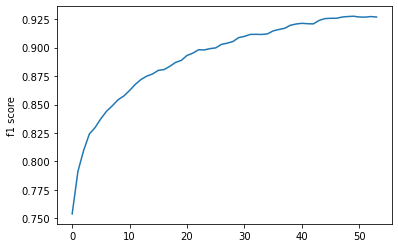

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(range(54), f1_score_list)
plt.ylabel("f1 score")
plt.savefig("result.jpg")